# Inférence & eval

In [77]:
import torch
import numpy as np
scores = torch.load('lastrun/run_info.pt')['scores']
hyperpar = torch.load('lastrun/run_info.pt')['hyperparams']

In [78]:
print(hyperpar)

{'thresholds': [0.8333333333333334, 8.333333333333334, 20.833333333333332], 'batch_size': 128, 'epochs': 30, 'lr_wd': {0: (0.0008, 1e-05), 4: (0.0001, 5e-05)}, 'oversampling': 0.9, 'data_dir': 'data', 'dataset_indexes': ['data/train.npz', 'data/val.npz'], 'wind_dir': None, 'input_len': 12, 'stride': 12, 'time_horizon': 6}


In [79]:
print(scores.keys())

dict_keys(['train_losses', 'val_losses', 'val_f1', 'f1_pers', 'val_bias', 'bias_pers', 'val_ts', 'ts_pers'])


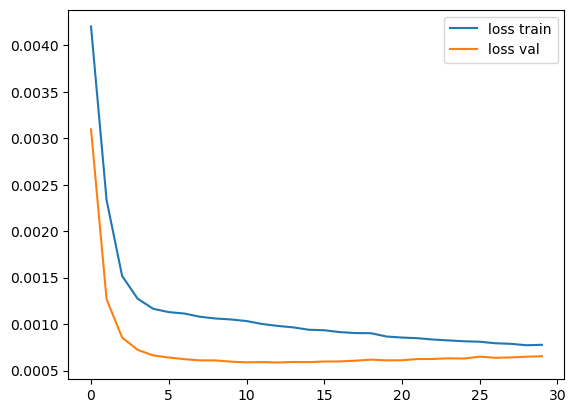

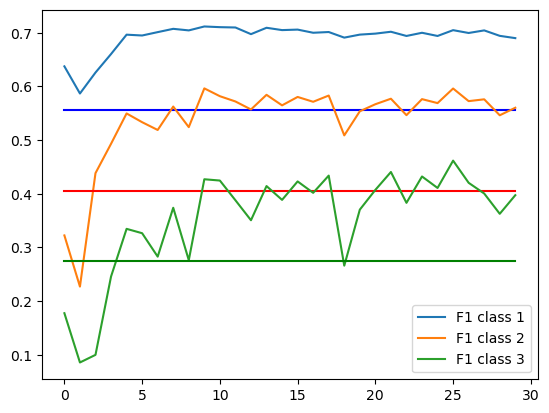

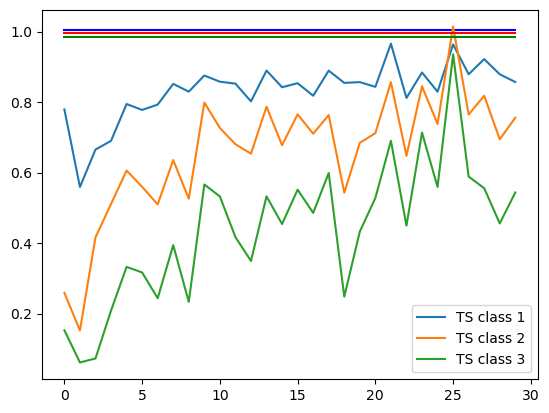

In [80]:
import matplotlib.pyplot as plt

def plot_scores( scores):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    plt.show()
    sc = scores['val_bias']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='TS class 1')
    plt.plot([scores['bias_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='TS class 2')
    plt.plot([scores['bias_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='TS class 3')
    plt.plot([scores['bias_pers'][2]]*l,'g')
    plt.legend()
    plt.show()
    
plot_scores(scores)


In [81]:
# get train, val and test datasets
from loader.meteonet import MeteonetDataset
from tqdm import tqdm
from loader.filesets import bouget21

wind_dir = hyperpar['wind_dir']
train_files, val_files, test_files = bouget21('data/rainmaps')

# datasets
train_ds = MeteonetDataset( train_files, 12, 18, 12, wind_dir=wind_dir, cached=f'data/train.npz', tqdm=tqdm)
val_ds   = MeteonetDataset( val_files, 12, 18, 12, wind_dir=wind_dir, cached=f'data/val.npz', tqdm=tqdm)
test_ds  = MeteonetDataset( test_files, 12, 18, 12, wind_dir=wind_dir, cached=f'data/test.npz', tqdm=tqdm)

# important!
val_ds.norm_factors = train_ds.norm_factors
test_ds.norm_factors = train_ds.norm_factors

In [82]:
from torch.utils.data import DataLoader
from loader.samplers import meteonet_sequential_sampler
test_sampler = meteonet_sequential_sampler( test_ds)
test_loader = DataLoader(test_ds, batch_size=64, sampler=test_sampler ) 

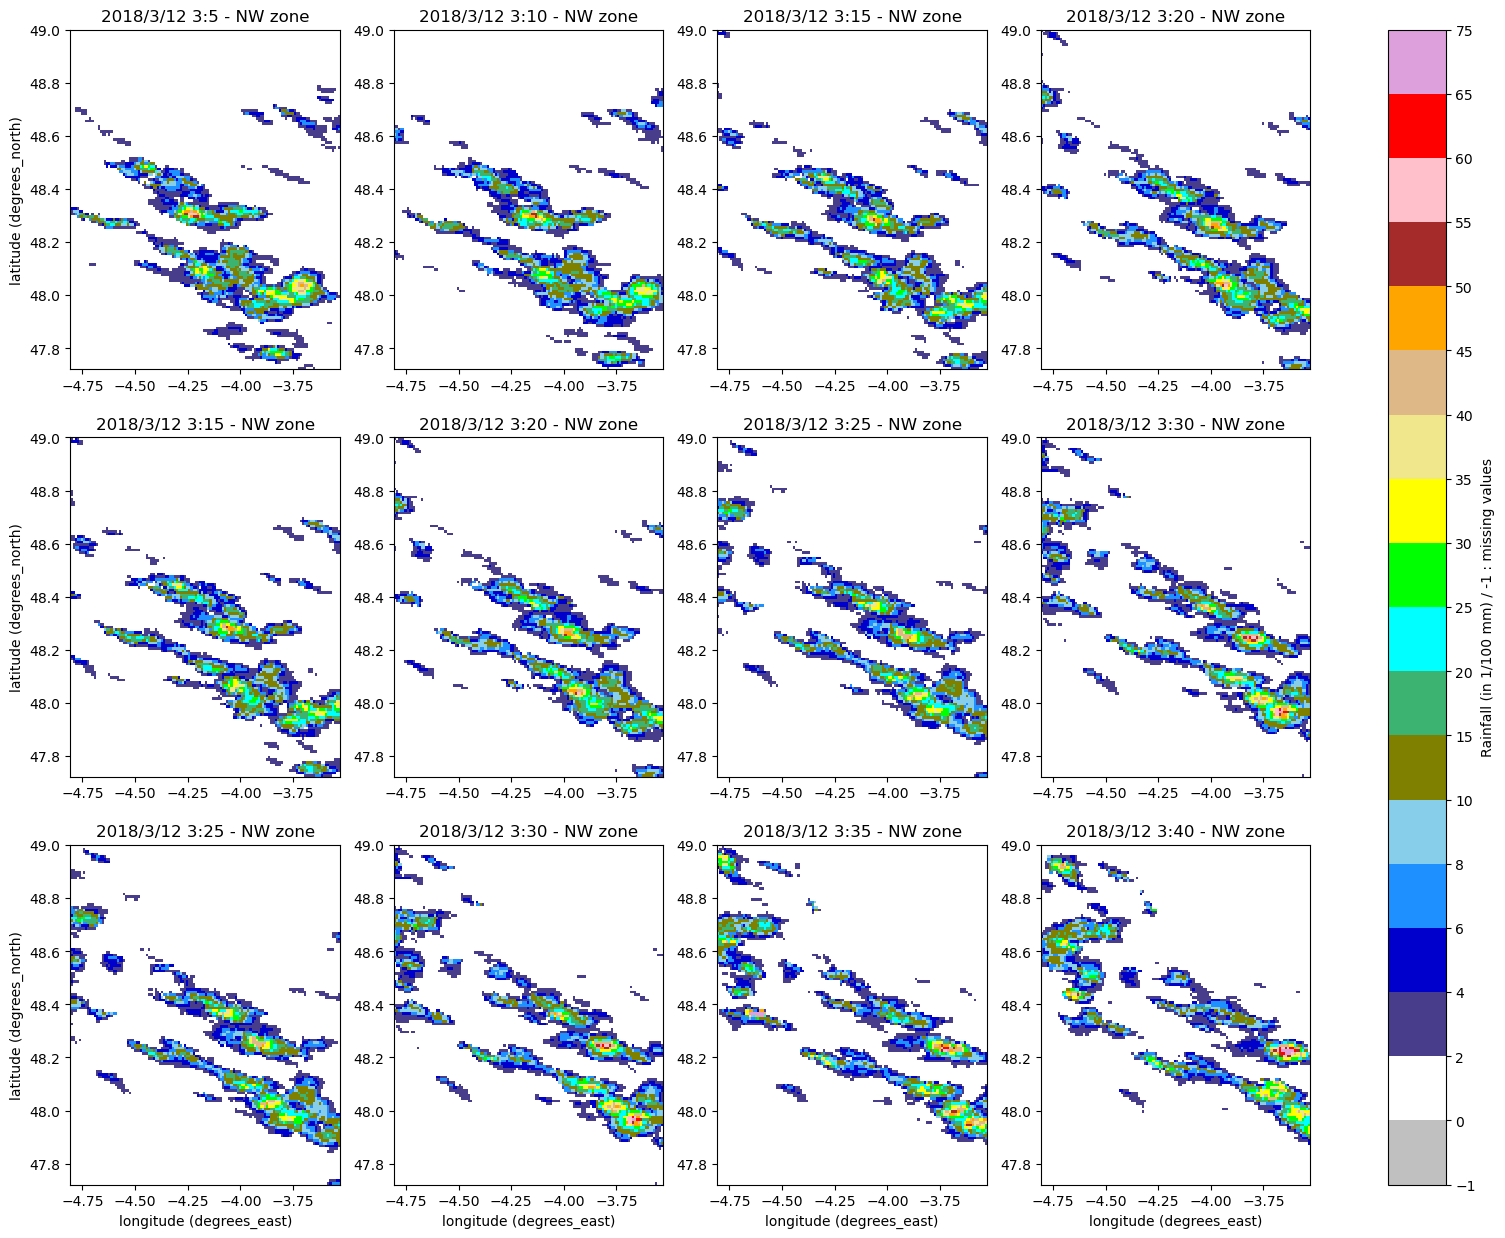

In [55]:
from loader.plots import plot_meteonet_rainmaps
from data.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

train_date = 2017,3,1,12,0 # dans train_ds
val_date = 2018,3,12,3,5 # dans val_ds

plot_meteonet_rainmaps( val_ds, val_date, lon, lat, zone, n=4)

In [83]:
from models.unet import UNet

# three models
if wind_dir:
    model = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
else:
    model = UNet( n_channels= 12, n_classes = 3, bilinear = True)

model.load_state_dict(torch.load('lastrun/model_last_epoch.pt')) #,  map_location=torch.device('cpu'))

<All keys matched successfully>

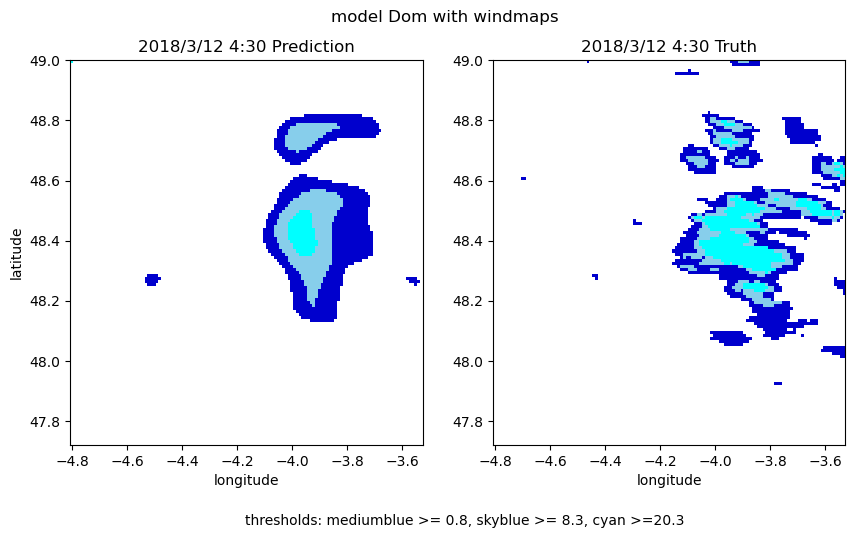

In [84]:
from loader.plots import plot_inference

thresholds = hyperpar['thresholds']

plot_inference( val_ds, val_date, model.to('cpu'), thresholds, lon, lat, zone, 'model Dom with windmaps')

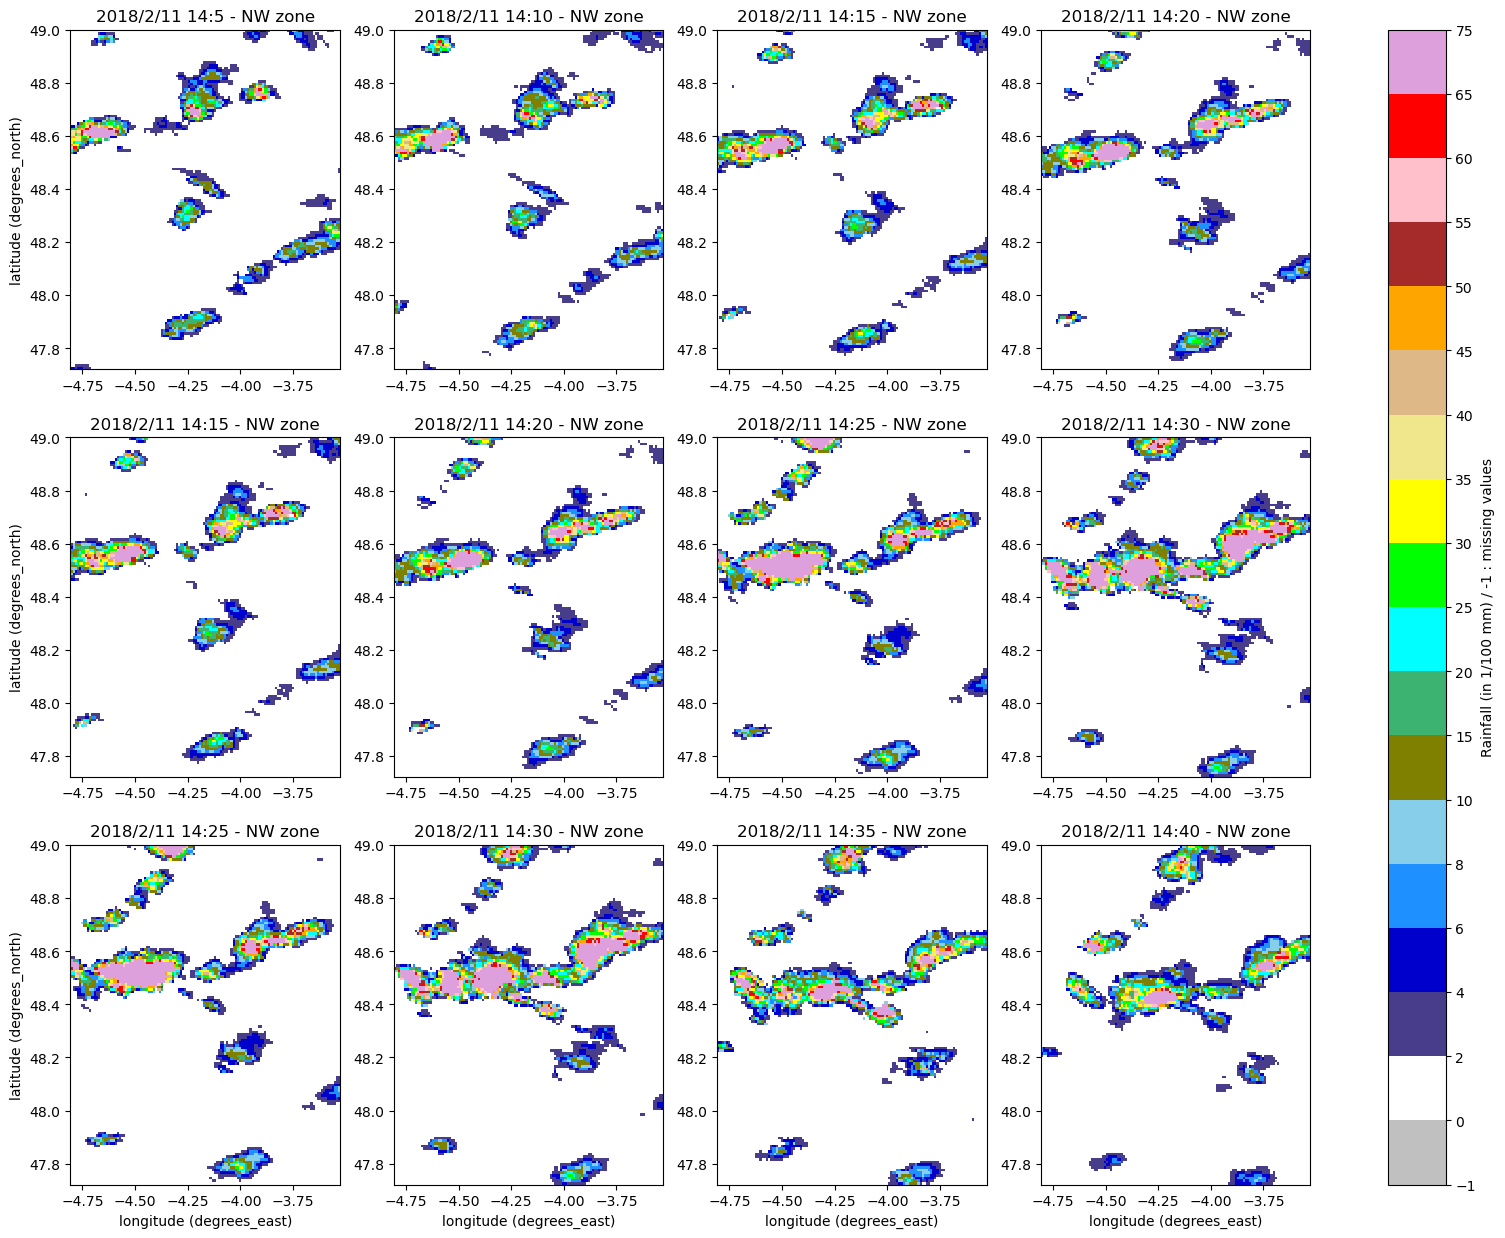

In [85]:
test_date = 2018, 2, 11, 14, 5
plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone, n=4)

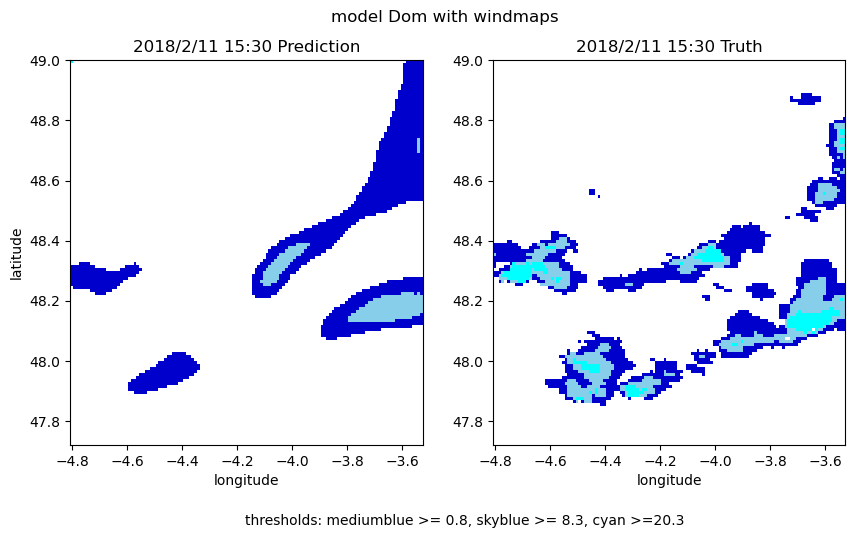

In [86]:
plot_inference( test_ds, test_date, model.to('cpu'), thresholds, lon, lat, zone, 'model Dom with windmaps')

torch.Size([1, 36, 128, 128])


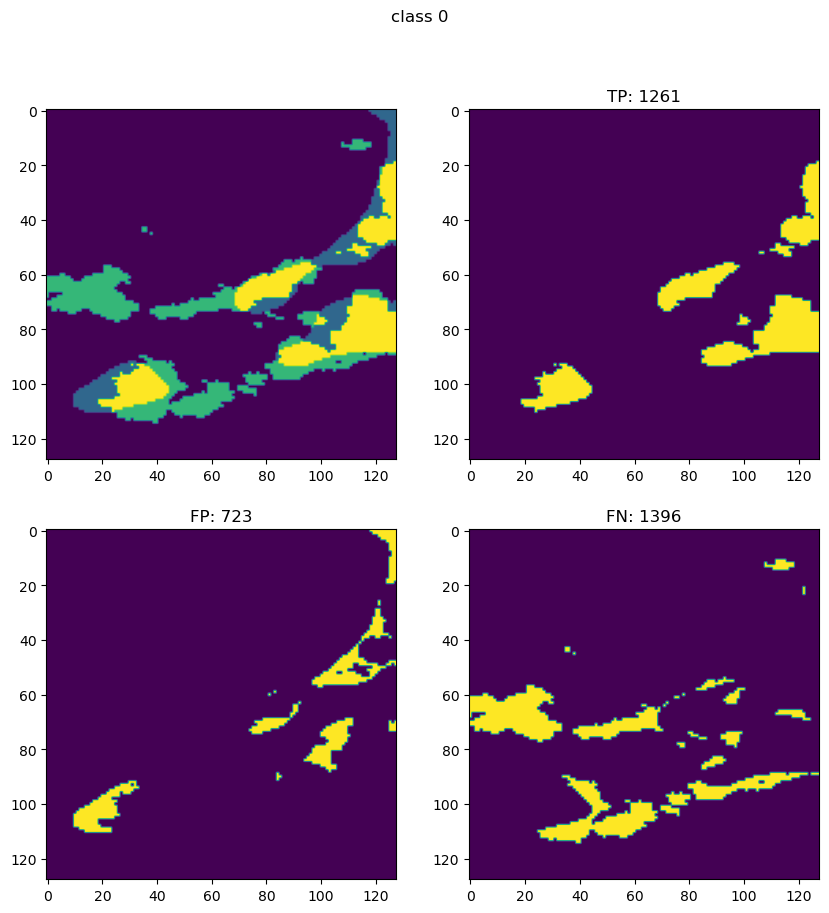

In [60]:
from loader.plots import plot_CT
plot_CT( test_ds, test_date, model.to('cpu'), thresholds, 0)

# evaluation on test set

In [61]:
from tqdm import tqdm
from loader.utilities import calculate_CT, calculate_BS, map_to_classes
import pandas as pd

device = torch.device('cuda')

def get_xy( data):
    return data['inputs'], map_to_classes(data['target'], thresholds)

def eval_test( dl, model, device):
    TPFPFN = 0
    model.to(device)
    model.eval()
    for data in tqdm(dl):
        x,y = get_xy(data)
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(x)
        TPFPFN += calculate_CT(torch.sigmoid(y_hat)>.5, y)
    return TPFPFN.cpu()

## Scores

$$
\begin{pmatrix}
TP = hits & FP = false\ alarms \\
FN = misses & TN = correct\ negatives 
\end{pmatrix}
$$


| Name | Def | Meaning | Used by | Alternative names |
| ---- | --- | ------- | ------- | ----------------- |
| Precision | $\frac{TP}{TP+FN}$ | bla  | [1,2] | POD [1] | 
| Recall | $\frac{TP}{TP+FP}$  |   | [1,3] | Success Ratio [3] | 
| $F_1$ | $2\frac{Prec\times Recall}{Prec+Recall}$ | Harmonic mean of prec/recall| [1] |
| Threat Score (TS) | $\frac{TP}{TP+FP+FN}$ | | [1,2,3] | Critical Success Index (CSI) |
| Bias | $\frac{Recall}{Prec}$ |  under (<1) or over (>1) estimate | [1,3] |
| False Alarm Rate (FAR) | $\frac{FP}{FP+TN}$ | | [1,2,3] |  Probability of False Detection (POFD) [3] |
| Heidke Skill Score (HSS)$^*$ | $\frac{2(TP\times TN - FP\times FN)}{(TP+FN)(FN+TN)+(TP+FP)(FP+TN)}$ | fraction of correct detection after removing random chance | [3]|
| Accuracy | $\frac{TP+TN}{TP+TN+FP+FN}$ | fraction of correct detection | [3] |
| Equitable Threat Score (ETS)$^{**}$ | $\frac{TP-TP_{random}}{TP+FP+FN-TP_{random}}$ | TS corrected of random chance|  [3] |  
| Odds Ratio Skill Score (ORSS) | $\frac{TP\times TN - FP\times FN}{TP\times TN + FP\times FN}$ | improvement of forecast over random chance|  [3] |


$^*$ The HSS formulation used here is an alternative definition due to Hogan, 2009. \
$^{**}$ $TP_{random} = \frac{(TP+FN)(TP+FP)}{TP+TN+FP+FN} $ 


[1] Bouget et al, 2021 \
[2] Zebiri et al, 2019 \
[3] Kumar et al, 2020: An embedded convolutional LSTM-based architecture for precipitation nowcasting using satellite data. PLoS ONE 15(3)

In [87]:
stats = eva| Heidke Skill Score (HSS)$^*$ | $\frac{2(TP\times TN - FP\times FN)}{(TP+FN)(FN+TN)+(TP+FP)(FP+TN)}$ | fraction of correct detection after removing random chance | [3]|
l_test( test_loader, model, device)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:24<00:00,  2.79it/s]


In [88]:
pd.DataFrame( stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,3250899,930347,218813
TN,64863957,68409629,69793367
FP,961393,462191,174522
FN,1555175,829257,444722


In [89]:
score_names = ['Pres/POD','Recall/Success Ratio','F1','TS/CSI','Bias','HSS','FAR','Accuracy', 'ETS', 'ORSS']
scores_BS = ['Precision', 'Recall',              'F1','TS',    'BIAS','HSS','FAR','Accuracy', 'ETS', 'ORSS']
pd.DataFrame( calculate_BS( stats, scores_BS), columns=['C1','C2','C3'], index=score_names)


,C1,C2,C3
Pres/POD,0.771765,0.668095,0.556302
Recall/Success Ratio,0.676415,0.528725,0.329769
F1,0.720951,0.590295,0.414077
TS/CSI,0.563661,0.418737,0.261096
Bias,0.876452,0.791393,0.592787
HSS,0.702009,0.581074,0.409948
FAR,0.014605,0.006711,0.002494
Accuracy,0.964370,0.981716,0.991233
ETS,0.540843,0.409517,0.257823
ORSS,0.985919,0.988028,0.989887
